We find significant discrepancies between the true galaxy properties and the values inferred from `iSpeculator` `model=emulator`. This notebook is to confirm these discrepancies and examine them in more detail to determine the cause.

In [1]:
import os 
import h5py 
import numpy as np 
import corner as DFM 
# --- gqp_mc ---
from gqp_mc import util as UT 
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# read noiseless Lgal spectra of the spectral_challenge mocks 
specs, meta = Data.Spectra(sim='lgal', noise='bgs0', lib='bc03', sample='mini_mocha') 
# read Lgal photometry of the mini_mocha mocks 
photo, _ = Data.Photometry(sim='lgal', noise='legacy', lib='bc03', sample='mini_mocha') 

In [4]:
meta.keys()

dict_keys(['galid', 't_lookback', 'dt', 'sfh_disk', 'sfh_bulge', 'Z_disk', 'Z_bulge', 'logM_disk', 'logM_bulge', 'logM_total', 't_age_MW', 'Z_MW', 'redshift', 'cosi', 'tau_ism', 'tau_bc', 'vd_disk', 'vd_bulge', 'logM_fiber', 'airmass', 'moon_alt', 'moon_ill', 'moon_sep', 'seeing', 'sun_alt', 'sun_sep', 'texp_total', 'transp', 'wave_sky', 'sbright_sky', 'sfr_1gyr', 'sfr_100myr'])

In [5]:
# local directory where the MCMC files are stored
dir_mcmc = '/Users/ChangHoon/data/gqp_mc/mini_mocha/ispeculator/'

In [18]:
mcmcs = [] 
for i in range(10): 
    f = h5py.File(os.path.join(dir_mcmc, 'lgal.specphoto.noise_bgs0_legacy.emulator.%i.postproc.hdf5' % i), 'r')
    mcmc = {} 
    for k in f.keys(): 
        mcmc[k] = f[k][...]
    mcmcs.append(mcmc)

In [20]:
mcmcs[0]['theta_names']

array([b'logmstar', b'beta1_sfh', b'beta2_sfh', b'beta3_sfh',
       b'beta4_sfh', b'gamma1_zh', b'gamma2_zh', b'tau', b'f_fiber',
       b'logsfr.100myr', b'logsfr.1gyr', b'logz.mw'], dtype='|S13')

In [81]:
mcmcs[0].keys()

dict_keys(['flux_photo_data', 'flux_photo_ivar_data', 'flux_photo_model', 'flux_spec_data', 'flux_spec_ivar_data', 'flux_spec_model', 'mcmc_chain', 'model', 'prior_range', 'redshift', 'theta_1sig_minus', 'theta_1sig_plus', 'theta_2sig_minus', 'theta_2sig_plus', 'theta_med', 'theta_names', 'wavelength_data', 'wavelength_model'])

In [82]:
theta_inf, theta_m1sig, theta_p1sig = [], [], []
for mcmc in mcmcs: 
    theta_inf.append(mcmc['theta_med'])
    theta_m1sig.append(mcmc['theta_1sig_minus'])
    theta_p1sig.append(mcmc['theta_1sig_plus'])
    
theta_inf = np.array(theta_inf)
theta_m1sig = np.array(theta_m1sig)
theta_p1sig = np.array(theta_p1sig)

## $\theta_{\rm true}$ vs $\theta_{\rm inf}$

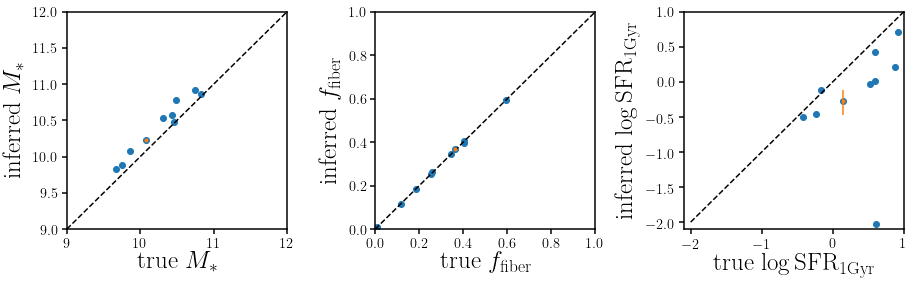

In [89]:
fig = plt.figure(figsize=(15,4))

# galaxy to focus on 
igal = 4

# total M* comparison 
sub = fig.add_subplot(131)
sub.plot([9., 12.], [9., 12.], c='k', ls='--')
sub.scatter(meta['logM_total'][:10], theta_inf[:,0])
sub.errorbar([meta['logM_total'][igal]], [theta_inf[igal,0]], 
             yerr=[[theta_inf[igal,0] - theta_m1sig[igal,0]], [theta_p1sig[igal,0] - theta_inf[igal,0]]], fmt='.C1')
sub.set_xlabel('true $M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel('inferred $M_*$', fontsize=25)
sub.set_ylim(9., 12.)

# f_fiber comparison 
f_fiber = (photo['fiberflux_r_true']/photo['flux_r_true'])

sub = fig.add_subplot(132)
sub.plot([0., 1.], [0., 1.], c='k', ls='--')
sub.scatter(f_fiber[:10], theta_inf[:,8])
sub.errorbar([f_fiber[igal]], [theta_inf[igal,8]], 
            yerr=[[theta_inf[igal,8] - theta_m1sig[igal,8]], [theta_p1sig[igal,8] - theta_inf[igal,8]]], fmt='.C1')
sub.set_xlabel(r'true $f_{\rm fiber}$', fontsize=25)
sub.set_xlim(0., 1.)
sub.set_ylabel(r'inferred $f_{\rm fiber}$', fontsize=25)
sub.set_ylim(0., 1.)

# log SFR 1gyr comparison
sub = fig.add_subplot(133)
sub.plot([-2., 1.], [-2., 1.], c='k', ls='--')
sub.scatter(np.log10(meta['sfr_1gyr'][:10]), theta_inf[:,10])
sub.errorbar([np.log10(meta['sfr_1gyr'][igal])], [theta_inf[igal,10]],
            yerr=[[theta_inf[igal,10] - theta_m1sig[igal,10]], [theta_p1sig[igal,10] - theta_inf[igal,10]]], fmt='.C1')
sub.set_xlabel(r'true $\log {\rm SFR}_{\rm 1Gyr}$', fontsize=25)
sub.set_xlim(-2.1, 1.)
sub.set_ylabel(r'inferred $\log {\rm SFR}_{\rm 1Gyr}$', fontsize=25)
sub.set_ylim(-2.1, 1.)

fig.subplots_adjust(wspace=0.4)

Now lets pick one galaxy and examine it in greater detail. 

## MCMC chain for one of the galaxies

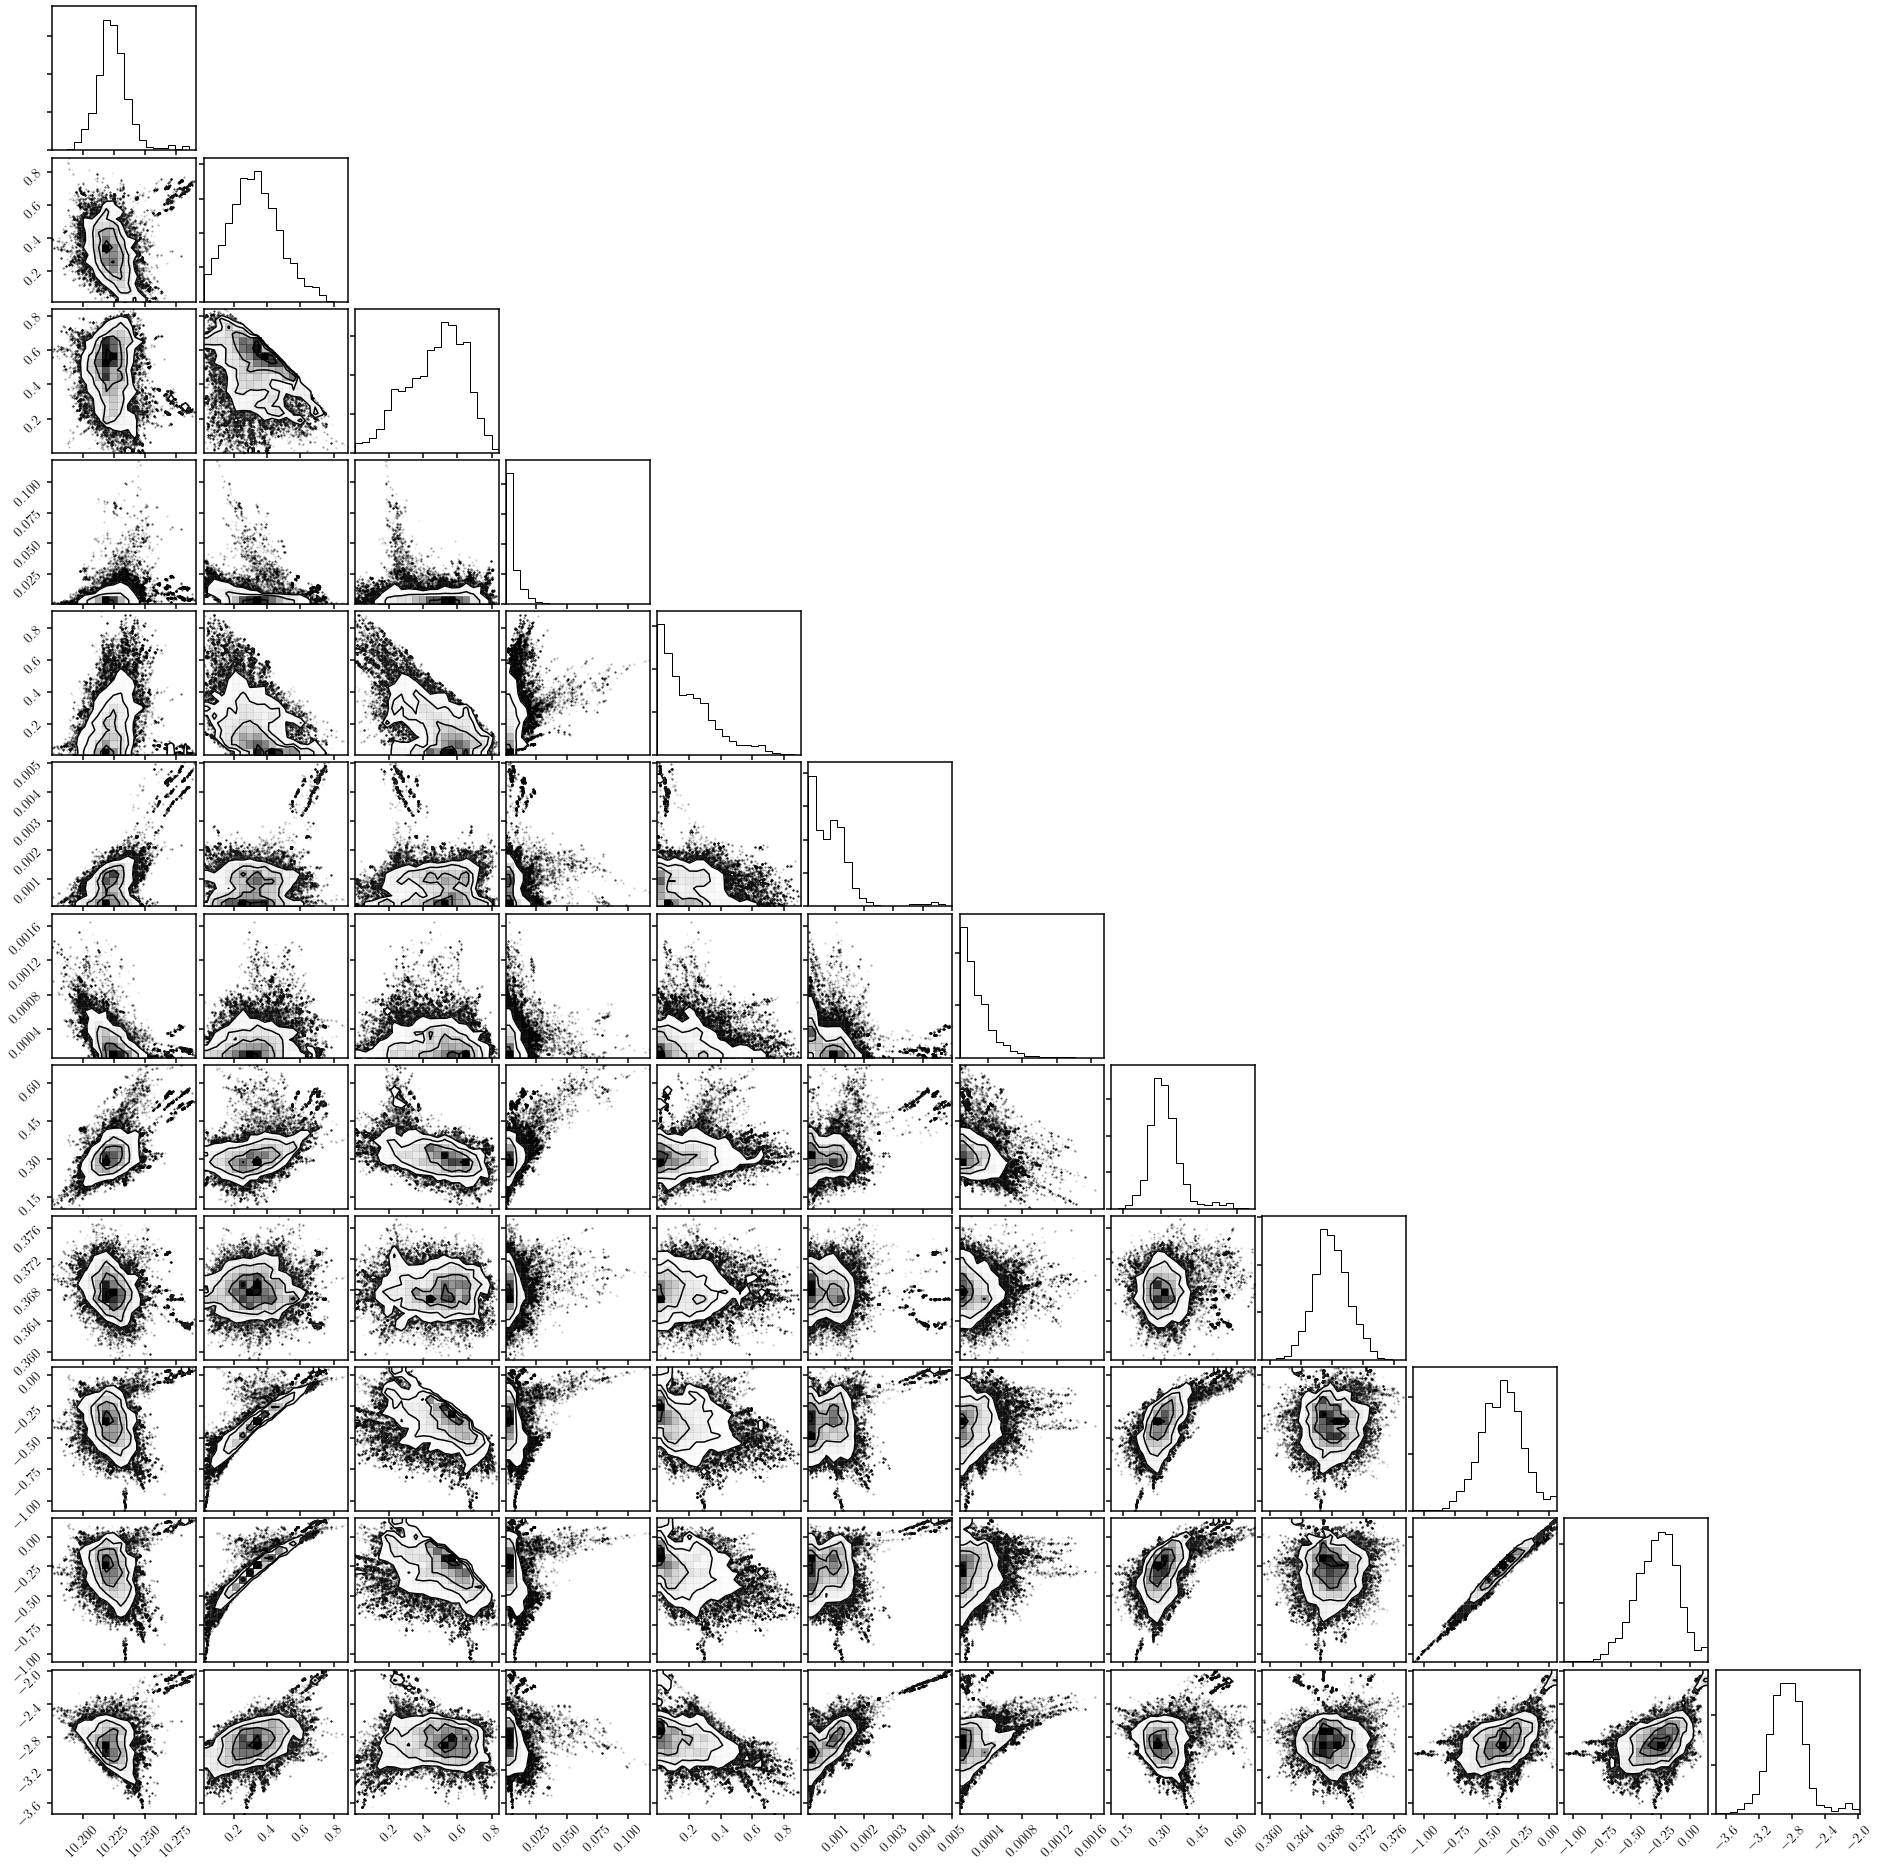

In [54]:
fig = DFM.corner(mcmcs[igal]['mcmc_chain'])

## Comparison of SED

In [59]:
from scipy.signal import medfilt

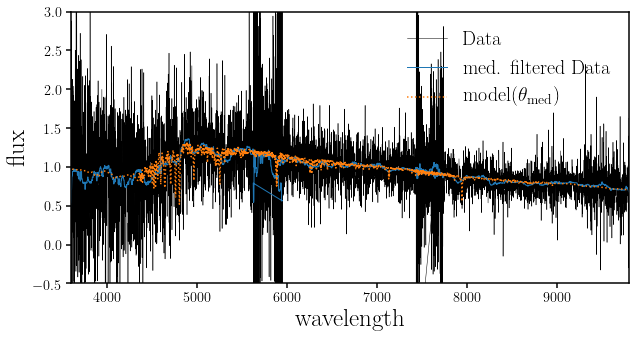

In [64]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(specs['wave'], specs['flux'][igal], c='k', lw=0.5, label='Data')
sub.plot(specs['wave'], medfilt(specs['flux'][igal], 101), c='C0', lw=1, label='med. filtered Data')
sub.plot(mcmcs[igal]['wavelength_model'], mcmcs[igal]['flux_spec_model'], c='C1', ls=':', label=r'model($\theta_{\rm med}$)')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3.6e3, 9800)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(-0.5, 3)
sub.legend(loc='upper right', fontsize=20)

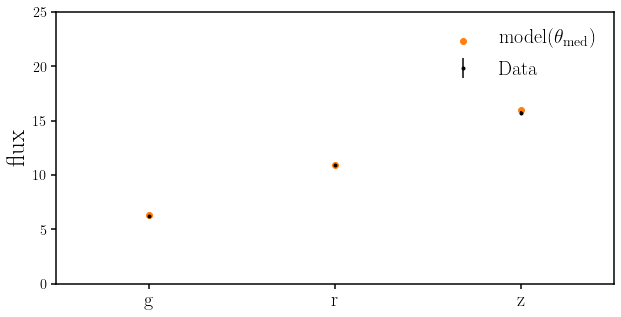

In [80]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.errorbar(range(photo['flux'].shape[1]), photo['flux'][igal], yerr=photo['ivar'][igal]**-0.5, fmt='.k', label='Data')
sub.scatter(range(len(mcmcs[igal]['flux_photo_model'])), mcmcs[igal]['flux_photo_model'], color='C1', label=r'model($\theta_{\rm med}$)')
sub.set_xticks([0, 1, 2])
sub.set_xticklabels(['g', 'r', 'z'], fontsize=20)
sub.set_xlim(-0.5, 2.5)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(0., 25)
sub.legend(loc='upper right', fontsize=20)

The fact that the median of the posterior reproduces the observed photometry and spectroscopy accurate suggests that the discrepancies in the inferred vs true properties are due to model limiations.